# Introduction

In this project, I will be looking at using agricultureal data from the [National Institue of Statistics of Rwanda](https://microdata.statistics.gov.rw/index.php/catalog/88/get_microdata) data repository to predict crop yield in different areas.  I believe one of the most powerful and useful applications of data science is within agriculutre.  Not only does this allow for more sustainable farming which combats climate change but also address key challenges such as food scacity.  Particulary in developing countries, sustainable food production can combat poverty and lead to stablitiy within the country.  This is a summary write up of the end-to-end process.  Later on, I will had more detailed write ups of each seperate part.

Below is an interactive map that shows the total crop yield per region for the country of Rwanda using the folium library.

In [1]:
# folium map
import folium
import geojson
import pandas as pd

with open("geo_data/rwa_district.geojson") as f:
    gj = geojson.load(f)

plot_production_data = pd.read_csv("raw_data/SeasonA_2017_LSF_Crop production.csv").iloc[:,1:]
plot_data = plot_production_data[['District', 'quanitiy harvested (kg)']]


m = folium.Map(location=[-1.944960, 30.062040], zoom_start=7)
m.choropleth(
    geo_data=gj,
    data=plot_data,
    columns=['District', 'quanitiy harvested (kg)'],
    key_on= 'feature.properties.District',
    fill_color='YlGn',
    legend_name='Crop Yield (Kg)')


display(m)

C:\Users\Delgado\anaconda3_1\lib\site-packages\folium\folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


## Data Engineering

Again, I got this data digging around the [National Institue of Statistics of Rwanda](https://microdata.statistics.gov.rw/index.php/catalog/88/get_microdata) data repository.  Note you will need to fill out a few forms describing why you want the data.  If you click on the "data description" tab for 2017 in the [repository](https://microdata.statistics.gov.rw/index.php/catalog/88/data_dictionary), we see that we get a wide range of data from fertilizer to crop production to pesticides information.  We also see that the data is divided into three seasons(A,B,C) and small/large scale farms.  In this first attempt, we will be looking at crop production and fertilizer data from season A and only for large scale farms during 2017.  Crop production will have information about our target variable (yield) and after some reading, fertilizer also seems to play a crucial role.  In the later attempts, we can expand to other seasons, datasets, and farm types, but for now we are going to start small and try to extract immediate value.  Finally, once a general pipeline is created, going back and adding additional data should have less overhead.

We'll first import all the important libraries.  These were added as they were needed during the project.  Note, there is a custom library `Aggro_DE` which is a toolkit I wrote to help process the data and reduce the amount of repeated code.  

In [21]:
import pandas as pd  
import Aggro_DE as AgDE 
from IPython.display import HTML, display

### Libraries for classification model ###
import numpy as np

To begin with, we can download the `SeasonA_2017_LSF_Crop production.dta` and `SeasonA_2017_LSF_Fertilizers.dta` files to a local folder.  If you load in this data, you'll notice that the column names are codes that don't mean anything.  

In [3]:
raw_data = pd.read_stata("raw_data/SeasonA_2017_LSF_Crop production.dta")
raw_data.head(3)

LSF_ID    s1q1    s1q2  s2q1         s2q2   s2q4  s2q5            s2q6  \
0  12001.0  Kigali  Gasabo   1.0  5474.153809  Mixed   4.0        Soybean    
1  12001.0  Kigali  Gasabo   1.0  5474.153809  Mixed   4.0     Tree tomato   
2  12001.0  Kigali  Gasabo   1.0  5474.153809  Mixed   4.0  Cooking banana   

          s2q7  s2q8  ...  s2q17   s2q18            s2q19  s2q20  s2q21  \
0  3649.435547   NaN  ...   23.0  5750.0  RAB/NAEB/SECTOR    0.0  140.0   
1  1824.717773   NaN  ...    NaN     NaN              NaN   50.0    0.0   
2  1642.246094  43.0  ...    NaN     0.0  RAB/NAEB/SECTOR  600.0  300.0   

   s2q22                            s2q23  s2q24  s2q25      crop_group  
0  140.0               Diseases and pasts     No    NaN        Soybean   
1   50.0  Good harvest as it was expected    Yes  900.0          Fruits  
2  900.0  Good harvest as it was expected     No    NaN  Cooking banana  

[3 rows x 30 columns]

Digging a little bit deeper into the repository, I found that the column names were listed for each data set in a PDF (example below).  Thus, I created excel documents with the column code and the respective column name (second figure below)

![](images/metadata_info.png)
![](images/variable_excel.png)


I then wrote a function int he `Aggro_DE` to link the excel document column names key to the actual dataset.  An example is shown below using the crop production data:

In [4]:
crop_production_data_names = "SeasonA_2017_LSF_Crop production"
crop_production_var_names = "2017_LSF_crop_production_var"

crop_production = AgDE.label_data(crop_production_data_names, crop_production_var_names)

crop_production.head()

LSF_ID Province District  Plot No  Plot area(m^2) Cropping_System  \
0  12001.0   Kigali   Gasabo      1.0     5474.153809           Mixed   
1  12001.0   Kigali   Gasabo      1.0     5474.153809           Mixed   
2  12001.0   Kigali   Gasabo      1.0     5474.153809           Mixed   
3  12001.0   Kigali   Gasabo      1.0     5474.153809           Mixed   
4  12001.0   Kigali   Gasabo      2.0    43546.945312            Pure   

   Crops_In_Plot               crop_name  crop area (m2)  number trees  ...  \
0            4.0                Soybean      3649.435547           NaN  ...   
1            4.0             Tree tomato     1824.717773           NaN  ...   
2            4.0          Cooking banana     1642.246094          43.0  ...   
3            4.0          Dessert banana      821.123047          20.0  ...   
4            1.0  Napia grass for fodder    43546.945312           NaN  ...   

   quanitiy improved seeds purchased improved seeds price  \
0                               23.0               5750.0   
1                                NaN                  NaN   
2                                NaN                  0.0   
3                                NaN                  0.0   
4                                NaN                  NaN   

  improved seeds origin quanitiy harvested (kg) remaining harvested  \
0       RAB/NAEB/SECTOR                     0.0               140.0   
1                   NaN                    50.0                 0.0   
2       RAB/NAEB/SECTOR                   600.0               300.0   
3       RAB/NAEB/SECTOR                   250.0                50.0   
4                   NaN                 32000.0              7200.0   

   total harvested                Production Status  Produce sold  \
0            140.0               Diseases and pasts            No   
1             50.0  Good harvest as it was expected           Yes   
2            900.0  Good harvest as it was expected            No   
3            300.0  Good harvest as it was expected            No   
4          39200.0  Good harvest as it was expected            No   

  farm gate price of crop      crop_group  
0                     NaN        Soybean   
1                   900.0          Fruits  
2                     NaN  Cooking banana  
3                     NaN  Dessert banana  
4                     NaN     Other crops  

[5 rows x 30 columns]

I then performed the usual checks on the data such as looking for missing values, outliers, and mix data types (strings in a numerical column)  Again, in later posts, I will go step by step into how I delt with these repective issues.  One thing to call out is that in columns that have categorical data such as "improved seeds origin" there are `NaN`s rather that something like a "N/A" option.  Thus, in such a case I added an additional category "N/A_improved seeds origin" using the code below:

In [5]:
print("Before adding N/A Category:\n")
print(crop_production["improved seeds origin"].value_counts())
print("\n")

add_category = "N/A_improved seeds origin"

crop_production["improved seeds origin"] = crop_production["improved seeds origin"].cat.add_categories([add_category])
crop_production["improved seeds origin"][crop_production["seeds type"] == "Traditional seeds"] = add_category

print("After adding N/A Category:\n")
print(crop_production["improved seeds origin"].value_counts())

Before adding N/A Category:

RAB/NAEB/SECTOR                    155
Shops of improved seeds            110
Recognized seed multipliers/NGO    104
Other (Specify)                     21
Name: improved seeds origin, dtype: int64


After adding N/A Category:

N/A_improved seeds origin          351
RAB/NAEB/SECTOR                    155
Shops of improved seeds            110
Recognized seed multipliers/NGO    104
Other (Specify)                     21
Name: improved seeds origin, dtype: int64


Below is a sample of the cleand up dataset after saving it to a seperate folder

In [6]:
cleaned_production_data = pd.read_csv("cleaned_data/MD_SeasonA_2017_LSF_Crop production.csv").iloc[:,1:]
cleaned_production_data.head()

LSF_ID Province District  Plot No  Plot area(m^2) Cropping_System  \
0  12001.0   Kigali   Gasabo      1.0        5474.154           Mixed   
1  12001.0   Kigali   Gasabo      1.0        5474.154           Mixed   
2  12001.0   Kigali   Gasabo      1.0        5474.154           Mixed   
3  12001.0   Kigali   Gasabo      1.0        5474.154           Mixed   
4  12001.0   Kigali   Gasabo      2.0       43546.945            Pure   

   Crops_In_Plot               crop_name  crop area (m2)         seeds type  \
0            4.0                Soybean       3649.43550     Improved seeds   
1            4.0             Tree tomato      1824.71780  Traditional seeds   
2            4.0          Cooking banana      1642.24610     Improved seeds   
3            4.0          Dessert banana       821.12305     Improved seeds   
4            1.0  Napia grass for fodder     43546.94500  Traditional seeds   

   quantity seeds sown  quanitiy improved seeds  quanitiy harvested (kg)  \
0                  0.0                     23.0                      0.0   
1                  0.0                      0.0                     50.0   
2                  0.0                      0.0                    600.0   
3                  0.0                      0.0                    250.0   
4                  0.0                      0.0                  32000.0   

   total harvested  crop_proportion  
0            140.0         0.666667  
1             50.0         0.333333  
2            900.0         0.300000  
3            300.0         0.150000  
4          39200.0         1.000000

I can then load in the fertilizer data using the same function from the `Aggro_DE` library.  

In [7]:
fertilizer_data_names = "SeasonA_2017_LSF_Fertilizers"
fertilizer_var_names = "2017_LSF_fertilizers_var"

fertilizer_data = AgDE.label_data(fertilizer_data_names, fertilizer_var_names)
fertilizer_data.head()

LSF_ID Province District  Plot No  Plot area(m^2) Organic fertilizer  \
0  12001.0   Kigali   Gasabo      1.0     5474.153600                 No   
1  12001.0   Kigali   Gasabo      2.0    43546.943029                 No   
2  12001.0   Kigali   Gasabo      3.0    37865.134384                Yes   
3  12001.0   Kigali   Gasabo      4.0    30846.701651                 No   
4  12001.0   Kigali   Gasabo      5.0    44567.784086                Yes   

   organic fertilizer used (kg)  organic fertilizer purchased (kg)  \
0                           NaN                                NaN   
1                           NaN                                NaN   
2                       10000.0                             5000.0   
3                           NaN                                NaN   
4                        5000.0                             5000.0   

   organic fertilizer cost inorganic fertilizer inorganic fertilizer type  \
0                      NaN                   No                       NaN   
1                      NaN                   No                       NaN   
2                  80000.0                  Yes                       DAP   
3                      NaN                   No                       NaN   
4                  60000.0                   No                       NaN   

  inorganic fertilizer unit  inorganic fertilizer used (kg)  \
0                       NaN                             NaN   
1                       NaN                             NaN   
2                        Kg                        118900.0   
3                       NaN                             NaN   
4                       NaN                             NaN   

   inorganic fertilizer purchased (kg)  inorganic fertilizer cost  \
0                                  NaN                        NaN   
1                                  NaN                        NaN   
2                                290.0                      410.0   
3                                  NaN                        NaN   
4                                  NaN                        NaN   

            source inorganic fertilizer crop inorganic fertilizer  
0                                   NaN                       NaN  
1                                   NaN                       NaN  
2  Government(MINAGRI/RAB/NAEB/District          Maize for fodder  
3                                   NaN                       NaN  
4                                   NaN                       NaN

I then applied the same data checks as before and again will dive deeper into that workflow in another post.  Beyond these usual checks, I wanted to make sure I was capturing how much of each type of inorganic fertilizer was being used.  Thus, I turned the "inorganic fertilizer type" into dummie columns and multipled those columns by the "inorganic fertilizer used (kg)" column.  Below is a sample of the cleaned up organic and inorganic data.  I split this fertilizer data up in this way in order to make merging easier.

In [8]:
cleaned_Ofertilizer_data = pd.read_csv("cleaned_data/MD_SeasonA_2017_LSF_OrganicFertilizers.csv").iloc[:,1:]
cleaned_Ofertilizer_data.head()

LSF_ID Province District  Plot No  Plot area(m^2)  Organic fertilizer  \
0  12001.0   Kigali   Gasabo      1.0     5474.153600                   0   
1  12001.0   Kigali   Gasabo      2.0    43546.943029                   0   
2  12001.0   Kigali   Gasabo      3.0    37865.134384                   1   
3  12001.0   Kigali   Gasabo      4.0    30846.701651                   0   
4  12001.0   Kigali   Gasabo      5.0    44567.784086                   1   

   organic fertilizer used (kg)  inorganic fertilizer  \
0                           0.0                     0   
1                           0.0                     0   
2                       10000.0                     1   
3                           0.0                     0   
4                        5000.0                     0   

      inorganic fertilizer type  inorganic fertilizer used (kg)  \
0  N/Ainorganic fertilizer type                             0.0   
1  N/Ainorganic fertilizer type                             0.0   
2                           DAP                        118900.0   
3  N/Ainorganic fertilizer type                             0.0   
4  N/Ainorganic fertilizer type                             0.0   

            source inorganic fertilizer  
0        N/Asource inorganic fertilizer  
1        N/Asource inorganic fertilizer  
2  Government(MINAGRI/RAB/NAEB/District  
3        N/Asource inorganic fertilizer  
4        N/Asource inorganic fertilizer

In [9]:
cleaned_IOfertilizer_data = pd.read_csv("cleaned_data/MD_SeasonA_2017_LSF_Inorganic_Fertilizers.csv").iloc[:,1:]
cleaned_IOfertilizer_data.head(10)

LSF_ID Province District  Plot No  Plot area(m^2)  Organic fertilizer  \
0  12001.0   Kigali   Gasabo      3.0    37865.134384                   1   
1  12001.0   Kigali   Gasabo      6.0    43255.799107                   1   
2  12001.0   Kigali   Gasabo      8.0   169087.335806                   1   
3  12001.0   Kigali   Gasabo     29.0    57698.689044                   1   
4  12001.0   Kigali   Gasabo     30.0    65585.026222                   1   
5  12001.0   Kigali   Gasabo     32.0     3761.818039                   1   
6  12001.0   Kigali   Gasabo     33.0     5528.747535                   1   
7  12002.0   Kigali   Gasabo      5.0   242249.752812                   1   
8  12003.0   Kigali   Gasabo      8.0   105113.149787                   1   
9  12003.0   Kigali   Gasabo      9.0    92874.042231                   1   

   organic fertilizer used (kg)  inorganic fertilizer         crop_name  \
0                       10000.0                     1  Maize for fodder   
1                       25000.0                     1             Maize   
2                       92000.0                     1             Maize   
3                       15000.0                     1  Maize for fodder   
4                       17500.0                     1  Maize for fodder   
5                        1000.0                     1  Maize for fodder   
6                        1300.0                     1  Maize for fodder   
7                        7230.0                     1             Maize   
8                      420400.0                     1  Maize for fodder   
9                      371600.0                     1  Maize for fodder   

         DAP  N/Ainorganic fertilizer type  NPK 17-17-17  Urea  Lliquid urea  \
0   118900.0                           0.0           0.0   0.0           0.0   
1   137350.0                           0.0           0.0   0.0           0.0   
2     5494.0                           0.0           0.0   0.0           0.0   
3      435.0                           0.0           0.0   0.0           0.0   
4   207870.0                           0.0           0.0   0.0           0.0   
5       30.0                           0.0           0.0   0.0           0.0   
6       30.0                           0.0           0.0   0.0           0.0   
7  1482150.0                           0.0           0.0   0.0           0.0   
8        0.0                           0.0         750.0   0.0           0.0   
9        0.0                           0.0         663.0   0.0           0.0   

   Other inorganic fertilizer (to specify)  NPK 20-10-10  KCL/MOP  NPK 25-5-5  
0                                      0.0           0.0      0.0         0.0  
1                                      0.0           0.0      0.0         0.0  
2                                      0.0           0.0      0.0         0.0  
3                                      0.0           0.0      0.0         0.0  
4                                      0.0           0.0      0.0         0.0  
5                                      0.0           0.0      0.0         0.0  
6                                      0.0           0.0      0.0         0.0  
7                                      0.0           0.0      0.0         0.0  
8                                      0.0           0.0      0.0         0.0  
9                                      0.0           0.0      0.0         0.0

## Merging the Data Together

I then merged the crop production, organic/inorganic fertilizer data together on the "lsf_id", "province", "district", "plot_no", "crop_name" columns.  Additionally, I used a function from the `Aggro_DE` library to detect which columns are categorical and, make dummie columns out of those categories, delete the origninal column, and append the dummie columns.  Below is an example of the final dataset we are going to train the model on.

In [10]:
model_data = pd.read_csv("cleaned_data/MD_SeasonA_2017_fertilizer_crop_production.csv").iloc[:,1:]
model_data.head()

lsf_id  plot_no  plot_area(m^2)_x  crops_in_plot  quantity_seeds_sown  \
0  12001.0      1.0          5474.154            4.0                  0.0   
1  12001.0      1.0          5474.154            4.0                  0.0   
2  12001.0      1.0          5474.154            4.0                  0.0   
3  12001.0      1.0          5474.154            4.0                  0.0   
4  12001.0      2.0         43546.945            1.0                  0.0   

   quanitiy_improved_seeds  quanitiy_harvested_(kg)  total_harvested  \
0                     23.0                      0.0            140.0   
1                      0.0                     50.0             50.0   
2                      0.0                    600.0            900.0   
3                      0.0                    250.0            300.0   
4                      0.0                  32000.0          39200.0   

   crop_proportion  organic_fertilizer_used_(kg)_x  ...  Sugar beet  \
0         0.666667                             0.0  ...           0   
1         0.333333                             0.0  ...           0   
2         0.300000                             0.0  ...           0   
3         0.150000                             0.0  ...           0   
4         1.000000                             0.0  ...           0   

   Sweet pepper  Sweet potato  Taro  Tomato  Tree tomato  Wheat  \
0             0             0     0       0            0      0   
1             0             0     0       0            1      0   
2             0             0     0       0            0      0   
3             0             0     0       0            0      0   
4             0             0     0       0            0      0   

   Both(Trad and Improved  Improved seeds  Traditional seeds  
0                       0               1                  0  
1                       0               0                  1  
2                       0               1                  0  
3                       0               1                  0  
4                       0               0                  1  

[5 rows x 109 columns]

## Model Building

Okay so now we have our nice clean dataset.  Here, we have the "quanitiy_harvested_(kg)" column as our target variable and mostly everything else as our features.  Some columns such as "lsf_id" will be dropped as they were just being used to merge data on.  The first step is to perform some exploritory data analysis to get a sense of what we are working with.  Right away if we plot our target variable in a histogram, we find that there are lots of zeros.

0.0         215
2000.0       10
600.0         7
100.0         7
500.0         6
           ... 
932405.0      1
282.0         1
2256.0        1
195.0         1
224616.0      1
Name: quanitiy_harvested_(kg), Length: 380, dtype: int64


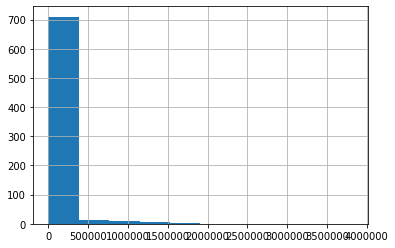

In [11]:
print(model_data["quanitiy_harvested_(kg)"].value_counts())
model_data["quanitiy_harvested_(kg)"].hist()

This is what's known as "zero-inflated data" which a whole research field on its own.  This inflation is probamatic because a lot of models assume that the target dataset has close to a gaussian distribution.  We can deal with this in a number ways:

* First us a classification model, then regression model
* Perform some sort of transformation (log, yeo-johnson) on the data to reduce the skew

After doing some iterating on my own, I decided to combine these approaches.  We will first build a classification model that will decide if a farm has zero or non-zero yield and then pass those predictions onto a regression model.  Theoritcallyt this should remove the zeros from our data, however, not all predictions are perfect.  Thus, before training the regression model, we'll use a transformation to make the target data have a more gaussian distriubtion.

![](images/model_flow.png)

First let's briefly go over building the classification model.  We'll first load in our data and create a target column with 1 for the farms with posative yield values and everything else to zero.

In [12]:
# %% Add Classification Values
model_data["non_zero_yield"] = np.where(
    model_data["quanitiy_harvested_(kg)"] > 0, 1, 0)

model_data.head()

lsf_id  plot_no  plot_area(m^2)_x  crops_in_plot  quantity_seeds_sown  \
0  12001.0      1.0          5474.154            4.0                  0.0   
1  12001.0      1.0          5474.154            4.0                  0.0   
2  12001.0      1.0          5474.154            4.0                  0.0   
3  12001.0      1.0          5474.154            4.0                  0.0   
4  12001.0      2.0         43546.945            1.0                  0.0   

   quanitiy_improved_seeds  quanitiy_harvested_(kg)  total_harvested  \
0                     23.0                      0.0            140.0   
1                      0.0                     50.0             50.0   
2                      0.0                    600.0            900.0   
3                      0.0                    250.0            300.0   
4                      0.0                  32000.0          39200.0   

   crop_proportion  organic_fertilizer_used_(kg)_x  ...  Sweet pepper  \
0         0.666667                             0.0  ...             0   
1         0.333333                             0.0  ...             0   
2         0.300000                             0.0  ...             0   
3         0.150000                             0.0  ...             0   
4         1.000000                             0.0  ...             0   

   Sweet potato  Taro  Tomato  Tree tomato  Wheat  Both(Trad and Improved  \
0             0     0       0            0      0                       0   
1             0     0       0            1      0                       0   
2             0     0       0            0      0                       0   
3             0     0       0            0      0                       0   
4             0     0       0            0      0                       0   

   Improved seeds  Traditional seeds  non_zero_yield  
0               1                  0               0  
1               0                  1               1  
2               1                  0               1  
3               1                  0               1  
4               0                  1               1  

[5 rows x 110 columns]

After dropping the irrelvant columns (such as lsf_id) as well as the "quanitiy_harvested_(kg)" since we won't have that when ingesting new data, we still have around 100 feature columns which is probamatic for a few reasons.  One, two or more features could be highly correlated to each other which would disrupt some of our models.  Additionally, some of the features might not be strong indicators for the target variable.  Thus, we can first check for the correlation among features and then look at correlation between the features and the target variable.  In a later write up, I will go into the details of the code but for now we can look at plots of all the correlations as well as the top most posatively correlated and the most negatively correlated.


display(HTML("<table><tr><td><img src='images/feature_target_correlation.png'></td><td><img src='images/feature_target_correlation_top_ten.png'></td></tr></table>"))

Though we can see here that there isn't a lot of variables that have a strong posative or negative correlation, we can still reduce the amount of columns by setting thresholds of corr > 0.75 and  corr <-0.75.  Setting these thresholds reduces the amount of features to 27 as seen below:

In [13]:
model_data = pd.read_csv("cleaned_data/reduced_data_set.csv").iloc[:,1:]
model_data.head()

plot_area(m^2)_x  total_harvested  crop_proportion  \
0          5474.154            140.0         0.666667   
1          5474.154             50.0         0.333333   
2          5474.154            900.0         0.300000   
3          5474.154            300.0         0.150000   
4         43546.945          39200.0         1.000000   

   other_inorganic_fertilizer_(to_specify)  East  Kigali  South  West  Gasabo  \
0                                      0.0     0       1      0     0       1   
1                                      0.0     0       1      0     0       1   
2                                      0.0     0       1      0     0       1   
3                                      0.0     0       1      0     0       1   
4                                      0.0     0       1      0     0       1   

   Gatsibo  ...  Irish potato  Leek  Maize  Napia grass for fodder  \
0        0  ...             0     0      0                       0   
1        0  ...             0     0      0                       0   
2        0  ...             0     0      0                       0   
3        0  ...             0     0      0                       0   
4        0  ...             0     0      0                       1   

   Other annual crop  Paddy rice  Sorghum  Soybean   Sweet potato  \
0                  0           0        0         1             0   
1                  0           0        0         0             0   
2                  0           0        0         0             0   
3                  0           0        0         0             0   
4                  0           0        0         0             0   

   non_zero_yield  
0               0  
1               1  
2               1  
3               1  
4               1  

[5 rows x 27 columns]

Before looking into model selection, you might notice that we have features with very different scales (i.e. plot area vs crop proportion) which could cause our model to overweight certain features.  We can medigate this issue by first splitting our model data into the target (non_zero_yield) and features.  These features can then be normalized using the code below.  

```
min_max_scaler = MinMaxScaler(feature_range=[0, 1])
features_norm = min_max_scaler.fit_transform(features)
features_norm = pd.DataFrame(features_norm)
features_norm.columns = features.columns
```

In [14]:
features_pre_norm = pd.read_csv("cleaned_data/features_pre_norm.csv").iloc[:,1:]
features_pre_norm.describe()

plot_area(m^2)_x  total_harvested  crop_proportion  \
count      7.400000e+02     7.400000e+02       740.000000   
mean       2.498742e+05     8.393440e+04         0.805713   
std        9.797250e+05     3.019007e+05         0.314200   
min        1.136620e+02     1.440000e+00         0.019802   
25%        3.582183e+03     3.560000e+02         0.625000   
50%        1.911516e+04     2.000000e+03         1.000000   
75%        7.062246e+04     2.574750e+04         1.000000   
max        1.481955e+07     3.821928e+06         1.000000   

       other_inorganic_fertilizer_(to_specify)        East      Kigali  \
count                             7.400000e+02  740.000000  740.000000   
mean                              6.955596e+03    0.686486    0.139189   
std                               1.323756e+05    0.464235    0.346378   
min                               0.000000e+00    0.000000    0.000000   
25%                               0.000000e+00    0.000000    0.000000   
50%                               0.000000e+00    1.000000    0.000000   
75%                               0.000000e+00    1.000000    0.000000   
max                               2.548000e+06    1.000000    1.000000   

            South        West      Gasabo     Gatsibo  ...  Cooking banana  \
count  740.000000  740.000000  740.000000  740.000000  ...      740.000000   
mean     0.101351    0.035135    0.112162    0.139189  ...        0.054054   
std      0.301998    0.184246    0.315779    0.346378  ...        0.226277   
min      0.000000    0.000000    0.000000    0.000000  ...        0.000000   
25%      0.000000    0.000000    0.000000    0.000000  ...        0.000000   
50%      0.000000    0.000000    0.000000    0.000000  ...        0.000000   
75%      0.000000    0.000000    0.000000    0.000000  ...        0.000000   
max      1.000000    1.000000    1.000000    1.000000  ...        1.000000   

       Irish potato        Leek       Maize  Napia grass for fodder  \
count    740.000000  740.000000  740.000000              740.000000   
mean       0.021622    0.002703    0.222973                0.075676   
std        0.145543    0.051952    0.416522                0.264657   
min        0.000000    0.000000    0.000000                0.000000   
25%        0.000000    0.000000    0.000000                0.000000   
50%        0.000000    0.000000    0.000000                0.000000   
75%        0.000000    0.000000    0.000000                0.000000   
max        1.000000    1.000000    1.000000                1.000000   

       Other annual crop  Paddy rice     Sorghum    Soybean   Sweet potato  
count         740.000000  740.000000  740.000000  740.000000    740.000000  
mean            0.002703    0.124324    0.031081    0.022973      0.022973  
std             0.051952    0.330174    0.173654    0.149919      0.149919  
min             0.000000    0.000000    0.000000    0.000000      0.000000  
25%             0.000000    0.000000    0.000000    0.000000      0.000000  
50%             0.000000    0.000000    0.000000    0.000000      0.000000  
75%             0.000000    0.000000    0.000000    0.000000      0.000000  
max             1.000000    1.000000    1.000000    1.000000      1.000000  

[8 rows x 26 columns]

In [15]:
features_post_norm = pd.read_csv("cleaned_data/features_post_norm.csv").iloc[:,1:]
features_post_norm.describe()

plot_area(m^2)_x  total_harvested  crop_proportion  \
count        740.000000       740.000000       740.000000   
mean           0.016854         0.021961         0.801788   
std            0.066111         0.078992         0.320547   
min            0.000000         0.000000         0.000000   
25%            0.000234         0.000093         0.617424   
50%            0.001282         0.000523         1.000000   
75%            0.004758         0.006736         1.000000   
max            1.000000         1.000000         1.000000   

       other_inorganic_fertilizer_(to_specify)        East      Kigali  \
count                               740.000000  740.000000  740.000000   
mean                                  0.002730    0.686486    0.139189   
std                                   0.051953    0.464235    0.346378   
min                                   0.000000    0.000000    0.000000   
25%                                   0.000000    0.000000    0.000000   
50%                                   0.000000    1.000000    0.000000   
75%                                   0.000000    1.000000    0.000000   
max                                   1.000000    1.000000    1.000000   

            South        West      Gasabo     Gatsibo  ...  Cooking banana  \
count  740.000000  740.000000  740.000000  740.000000  ...      740.000000   
mean     0.101351    0.035135    0.112162    0.139189  ...        0.054054   
std      0.301998    0.184246    0.315779    0.346378  ...        0.226277   
min      0.000000    0.000000    0.000000    0.000000  ...        0.000000   
25%      0.000000    0.000000    0.000000    0.000000  ...        0.000000   
50%      0.000000    0.000000    0.000000    0.000000  ...        0.000000   
75%      0.000000    0.000000    0.000000    0.000000  ...        0.000000   
max      1.000000    1.000000    1.000000    1.000000  ...        1.000000   

       Irish potato        Leek       Maize  Napia grass for fodder  \
count    740.000000  740.000000  740.000000              740.000000   
mean       0.021622    0.002703    0.222973                0.075676   
std        0.145543    0.051952    0.416522                0.264657   
min        0.000000    0.000000    0.000000                0.000000   
25%        0.000000    0.000000    0.000000                0.000000   
50%        0.000000    0.000000    0.000000                0.000000   
75%        0.000000    0.000000    0.000000                0.000000   
max        1.000000    1.000000    1.000000                1.000000   

       Other annual crop  Paddy rice     Sorghum    Soybean   Sweet potato  
count         740.000000  740.000000  740.000000  740.000000    740.000000  
mean            0.002703    0.124324    0.031081    0.022973      0.022973  
std             0.051952    0.330174    0.173654    0.149919      0.149919  
min             0.000000    0.000000    0.000000    0.000000      0.000000  
25%             0.000000    0.000000    0.000000    0.000000      0.000000  
50%             0.000000    0.000000    0.000000    0.000000      0.000000  
75%             0.000000    0.000000    0.000000    0.000000      0.000000  
max             1.000000    1.000000    1.000000    1.000000      1.000000  

[8 rows x 26 columns]

We can see that all the data is now roughly on the same scale.  We can then train-test-split this data so we have a hold out set that our model will never see during training.  

##  Classification Model Selection

Now that we finally have our cleaned up model data, we can begin to select a model.  My general approach is to first start with simple but explainable models and then increase in complexity while losing interpotablitiy.  I believe one of the issues in "data science" is many non-technical stakeholders have issues buying into what they percieve as a magical black box. Having a model that is simpler will allow one to more eailsy communicate how the model is working and is generally easier to work with.  Additionally, a data scientist needs to think about the infrastructure of their company as certain models might be difficult to impliment.  As with many things in "data science" this question is very nuanced, but we digress.  


I have writen re-usable code that will take in a list of models, do k-fold cross validation, and return the average of the desired metric, the standard deviation, and time to train.  This methodology will allow use to quickly iterate over out-of the box models and decide which one we should focus on.  Below is the function and the list of classification models we want to iteratre over.  Again, going from simple and explainable to complex and low interportablitiy.

```
def compare_algorithms(algorithms, X_data, y_data, scoring_method='roc_auc',
                       num_folds=3, seed=5):
    """
    Intake: list of (names: algorithms) to compare scoring metric and run time using cross fold validation.
    Returns: Data frame with a summary of the data and the MSE for each fold of each technique.
    """
    warnings.filterwarnings("ignore")
    results = []
    names = []
    times = []
    results_mean = []
    results_std = []
    for name, model in algorithms:
        print("Working on model: " + str(model))
        kfold = KFold(n_splits=num_folds, random_state=seed)
        start = time.time()
        cv_results = cross_val_score(
            model, X_data, y_data, cv=kfold, scoring=scoring_method)
        results.append(cv_results)
        results_mean.append(cv_results.mean())
        results_std.append(cv_results.std())
        run_time = time.time()-start
        names.append(name)
        times.append(run_time)

    algorithms_df = pd.DataFrame(
        {'Names': names,
         'Mean Metric': results_mean,
         'Std': results_std,
         'Time (s)': times,
         })

    return algorithms_df, results
    
    
  models = []
# High Interoperability

models.append(('SVC', SVC()))  # Features < Samples
models.append(('LinearSVC', LinearSVC()))
models.append(('GaussianNB', GaussianNB()))
# Medium Interoperability

models.append(('Ridge', RidgeClassifier()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))

# Low Interoperability
models.append(('RandomForest', RandomForestClassifier()))

single_model_compare, results = compare_algorithms(
    models, X_train, y_train, num_folds=3, seed=42)  
```

Here, we'll use the 'roc_auc" metric as this gives us a good balance between precision and recall.  We can print out and plot our results below:

![](images/compare_class_alg.png)

          Names  Mean Metric    Std     Time (s)
           SVC     0.760778  0.037427  0.085796
     LinearSVC     0.791105  0.044924  0.039894
         Ridge     0.793658  0.048247  0.040266
           KNN     0.751409  0.044696  0.058844
          CART     0.615148  0.027653  0.032912
      RandomForest 0.782547  0.025201  1.252187

Interesting, we can see that both the LinearSVC and Ridge models have close to the same roc_auc score.  Going back to our previous discussion, let's select the LinearSVC model as I feel it's easiler to show to a client or stakeholder how it generally works.  

Now that we have tested the out of the box model, we can now tune the parameters to better fit our training data.  This is also known as hyperparameter tuning.  Since LinearSVC has only one parameter, I'll skip the details of this process for now.  Again, in a later post, I'll go more in depth for this section.  The bottom line is that the out of the box model performs slightly better on the held out test data than any tuned version.

We can now use this LinearSVC to predict if the held out test data is going to have a posative yield or not and then merge that prediction onto the orignal data.  We can then save this new dataset to a scandliously named folder "classified_data" for using in our regession model to predict yield.

### Make diagram

```
base_model.fit(X_train, y_train)
preds = pd.DataFrame(base_model.predict(X_test), columns=["model_guess_zero"])

preds.index = X_test.index


regress_data = preds.merge(raw_data, how="left",
                           left_index=True, right_index=True)

regress_data = regress_data[regress_data["model_guess_zero"] == 1]
regress_data = regress_data.drop(
    ["model_guess_zero", "non_zero_yield"], axis=1)

folder_path = "classified_data"
file_name = "seasonA_clasified_data"
save_path = folder_path + "/" + file_name + ".csv"

regress_data.to_csv(save_path)

```

## Prediction Crop Yield- Regression Model

Now that we have our dataset with a reduced amount of farms with zero yield, we can begin building our regression model to predict crop yield.  Our target variable will be the `quanitiy_harvested_(kg)` with everything else being our features.  Again, in a later post, I will lay out this section step by step, but for now we can look at a high level summary of the process.  Let's load in the data and see how are target variable is looking from the classifed model.

In [16]:
regress_model_data = pd.read_csv("classified_data/seasonA_clasified_data.csv").iloc[:,1:]
class_model_data = pd.read_csv("cleaned_data/MD_SeasonA_2017_fertilizer_crop_production.csv").iloc[:,1:]
regress_model_data.head()

lsf_id  plot_no  plot_area(m^2)_x  crops_in_plot  quantity_seeds_sown  \
0  12005.0      5.0         5519.4570            1.0                  0.0   
1  52019.0      4.0         4067.5269            2.0                  0.0   
2  51017.0     10.0        29553.0350            1.0                 50.0   
3  22014.0      1.0       670168.9400            1.0               1641.0   
4  51005.0     10.0         1352.9701            1.0                 10.0   

   quanitiy_improved_seeds  quanitiy_harvested_(kg)  total_harvested  \
0                     12.6                   9350.0           9350.0   
1                      0.0                   9200.0          19200.0   
2                      0.0                     40.0             40.0   
3                      0.0                  82050.0          82050.0   
4                      0.0                     30.0             30.0   

   crop_proportion  organic_fertilizer_used_(kg)_x  ...  Sugar beet  \
0            1.000                           400.0  ...           0   
1            0.900                             0.0  ...           0   
2            0.375                             0.0  ...           0   
3            1.000                         13500.0  ...           0   
4            1.000                           200.0  ...           0   

   Sweet pepper  Sweet potato  Taro  Tomato  Tree tomato  Wheat  \
0             0             0     0       0            0      0   
1             0             0     0       0            0      0   
2             0             0     0       0            0      0   
3             0             0     0       0            0      0   
4             0             0     0       0            0      0   

   Both(Trad and Improved  Improved seeds  Traditional seeds  
0                       0               1                  0  
1                       0               1                  0  
2                       0               0                  1  
3                       0               0                  1  
4                       0               0                  1  

[5 rows x 109 columns]

0.0         46
2000.0       5
3000.0       4
30.0         4
1500.0       4
            ..
27000.0      1
112500.0     1
36750.0      1
185000.0     1
9200.0       1
Name: quanitiy_harvested_(kg), Length: 201, dtype: int64


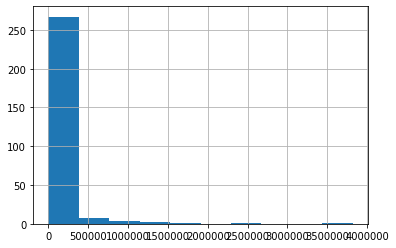

In [17]:
print(regress_model_data["quanitiy_harvested_(kg)"].value_counts())
regress_model_data["quanitiy_harvested_(kg)"].hist()

Okay, we can still see that there are a few zeros in there, however, this is much less than before doing the classificaion model.  

Similar to the classification modeling, we have ~ 100 features and ideally we could remove ones that are superfluous.  We'll first check for high correlations between features and remove one of the pairs.  Then we can check for correlation between the features and the target variable (quanitiy_harvested_(kg))

![](images/feature_target_correlation_regression.png)

We'll do a similar thresholding and remove features that don't have a lot of correation with the target varible giving us the dataset below.

In [18]:
clean_regress_data = pd.read_csv("cleaned_data/cleaned_regress_data.csv").iloc[:,1:]
clean_regress_data.head()

plot_area(m^2)_x  crops_in_plot  total_harvested  crop_proportion  \
0         5519.4570            1.0           9350.0            1.000   
1         4067.5269            2.0          19200.0            0.900   
2        29553.0350            1.0             40.0            0.375   
3       670168.9400            1.0          82050.0            1.000   
4         1352.9701            1.0             30.0            1.000   

   npk_20-10-10  kcl/mop  Kigali  South  Gasabo  Gatsibo  ...  Rusizi  \
0           0.0      0.0       1      0       1        0  ...       0   
1           0.0      0.0       0      0       0        0  ...       0   
2           0.0      0.0       0      0       0        0  ...       0   
3           0.0      0.0       0      1       0        0  ...       0   
4           0.0      0.0       0      0       0        0  ...       0   

   Rwamagana  Mixed  Bush bean  Cooking banana  Dessert banana  Paddy rice  \
0          0      0          0               0               0           0   
1          0      1          0               0               0           0   
2          1      0          0               0               0           0   
3          0      0          0               0               0           1   
4          1      0          0               0               0           0   

   Both(Trad and Improved  Improved seeds  quanitiy_harvested_(kg)  
0                       0               1                   9350.0  
1                       0               1                   9200.0  
2                       0               0                     40.0  
3                       0               0                  82050.0  
4                       0               0                     30.0  

[5 rows x 25 columns]

Awesome, we now have ~25 columns that we can use to predict crop yield.  Before we going into selecting a model, however, we need to deal with the fact that the target variable isn't close to being gaussian which would cause problems when applying our models.  As noted before, we can apply a transformation to our data to make it more gaussian and then apply the inverse of the transformation at the end when we want real yield values.  There are a number of transforamtions we could use, after some experiemntation on my part, I've found a `y=log(x+1)` works the best.  We need that `+1` as the `log(0)` is undefined.  One can see how the target distribution changes below

Target variable skew:7.368866522715992


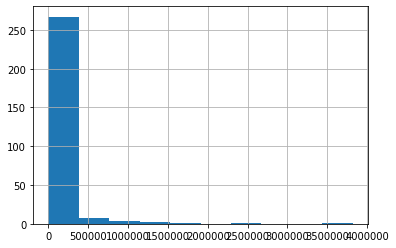

In [19]:
target = regress_model_data["quanitiy_harvested_(kg)"]

target.hist()
print("Target variable skew:" + str(target.skew()))

Transformed Target variable skew:-0.18300647342271747


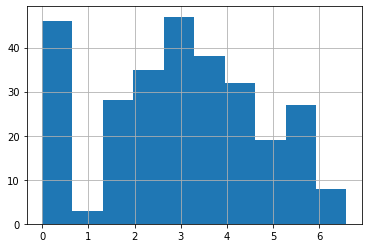

In [20]:
target_transformed = np.log10(target+1)
target_transformed.hist()
print("Transformed Target variable skew:" + str(target_transformed.skew()))

## Regression Model Selection

Now that we have a better distribution for our target variable we follow similar steps from our classification model approach by first normalizing our features and then train test splitting the data.  Again, we can use the same model selection methodogy in quickly iterating over a list of models ranging from simple and interpotable to complex and difficult to explain.  We can use the same `compare_algorithms` function as before.  Innstead of using 'roc_auc' as our metric, we'll use the default 'root mean squared error' (RMSE).

```
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))
models.append(('Bagging', RandomForestRegressor()))

single_model_compare, results = compare_algorithms(
    models, X_train, y_train, num_folds=7)
```

Plotting the outputs of `compare_algorithms` results in:

![](images/compare_regress_alg.png)

            Names Mean RMSE   Std     Time (s)
             LR   1.545303  0.245813  7.356796
          LASSO   1.744941  0.136792  0.056366
             EN   1.744941  0.136792  0.042867
            KNN   1.305129  0.234482  0.195512
           CART   1.329593  0.171099  0.117244
            SVR   1.402921  0.184546  0.060867
    Random Forest 1.072801  0.195728  1.624238



Interestingly, our randowm forest regression model had the lowest RMSE score hinting that perhaps other bagging or boosting models would perform better.  Let's again use `compare_algorithms` with these types of models and then plot the results.

```
ensemble_methods = []
ensemble_methods.append(('AdaBoost', AdaBoostRegressor()))
ensemble_methods.append(('GradientBoosting', GradientBoostingRegressor()))
ensemble_methods.append(('ExtraTree', ExtraTreesRegressor()))
ensemble_methods.append(('Random Forest', RandomForestRegressor()))

single_model_compare, results = compare_algorithms(
    ensemble_methods, X_train, y_train, num_folds=7)

```

![](images/compare_regress_alg_bagging.png)

            Names    Mean RMSE    Std     Time (s)
          AdaBoost   1.159807  0.164119  0.535093
    GradientBoosting 1.033405  0.214740  0.357280
         ExtraTree   1.129044  0.210098  0.980065
       Random Forest 1.075588  0.191079  1.117965

Here we can see that the Gradient Boosting Method (GBM) has the lowest RMSE score so we'll select that one to use.  Let's now see if we can tune the model parameters to improve the preformance.  Unlike the LinearSVC model, the GBM model has a number of dials we can turn.  Again using RandomCV, we can randomly search across combinations of parameters and compare the resulting model performance using RMSE.

```
GBM = GradientBoostingRegressor(random_state=42)

loss = ['ls', 'lad', 'huber', 'quantile']
learning_rate = [0.01, 0.1, 0.5]
n_estimators = [int(x) for x in np.linspace(start=50, stop=200, num=10)]
max_features = ['auto', 'sqrt']

max_depth = [int(x) for x in np.linspace(start=3, stop=50, num=10)]
min_samples_split = [2, 10, 100]
# Want to pick small values to prevent over fitting

learning_rate = [0.002, 0.02, 0.2]
learning_rate = [x for x in np.linspace(start=0.01, stop=0.15, num=20)]

min_samples_leaf = [1, 20, 40, 60, 80]

random_grid = {'n_estimators': n_estimators,
               'loss':loss,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'learning_rate': learning_rate}

GBM_random = RandomizedSearchCV(estimator=GBM, param_distributions=random_grid,
                                n_iter=40, cv=3, verbose=2, random_state=42, n_jobs=-1)
GBM_random.fit(X_train, y_train)

```
This search results in the best parameters being: 
`'n_estimators': 66, 'min_samples_split': 100, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 23, 'loss': 'huber', 'learning_rate': 0.04684210526315789`

We then need to check if this tuned model is any better than our out of the box model.  I wrote a custom function `evaluate_model` that will do a kfold cross validation and give the average metric score.  We can apply this function to our generic model and tuned model to compare the outputs which results in:

```
Model Performance of Base model Gradient Boosting
Root Mean Squared Error: 1.5550, std: 0.0610.
Model Performance of RandomCV Gradient Boosting
Root Mean Squared Error: 1.8564, std: 0.0759.
```

Okay, so our randomly tuned model doesn't perform better.  Let's try doing a focused Grid search where the method will look at all combinations of the parameters we give it.  We'll search around the parameters given from our RandomCV.

```
param_grid = {'n_estimators': [190, 200, 210, 220],
              'loss': ['ls'],
              'max_features': ['sqrt'],
              'max_depth': [2, 3, 4, 5],
              'min_samples_split': [2, 5, 10, 15],
              'min_samples_leaf': [1, 2, 3],
              'learning_rate': [0.001, 0.01, 0.015]}


# Create a based model
GBM = GradientBoostingRegressor()
# Instantiate the grid search model
GBM_grid_search = GridSearchCV(estimator=GBM, param_grid=param_grid,
                               cv=3, n_jobs=-1, verbose=2)
GBM_grid_search.fit(X_train, y_train)
```
This gives us the 'best' parameters from this search as being:
```
'learning_rate': 0.015, 'loss': 'ls', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 15, 'n_estimators': 220
```
Like with the randomCV search we can compare this tuned model with the out of the box model which results in:

Model Performance of Baseline Gradient Boosting
Root Mean Squared Error: 1.4900, std: 0.0187.

Model Performance of RandomCV Gradient Boosting
Root Mean Squared Error: 1.8564, std: 0.0759.

Model Performance of GridCV Gradient Boosting
Root Mean Squared Error: 1.3447, std: 0.0769.


Awesome, so while the randomCV search didn't make our model better, our focused grid search produced a slightly lower RMSE score with a small std.  Before we use this GBM model to predict yield, remember we used a transformation for our target data to make it more gaussian.  Thus, if we want real yield values, we need to do the inverse transformtion.  This can simply be done with the function below:

`def inverse_transform(temp_data):`

Now we can predict our target yield value using our hold out test set and look at the produced RMSE score.

```
best_grid = GradientBoostingRegressor(**estimators_grid)
best_grid.fit(X_train, y_train)
preds = best_grid.predict(X_test)

pred_values = inverse_transform(preds)
actual_values = inverse_transform(y_test)

mse = mean_squared_error(actual_values, pred_values)

rmse = math.sqrt(mse) 
print(rmse)

```
Which results in:

RMSE = 22847.44 Kg.  

On face value this seems rather large.  Let's compare this to the statistics of our target yield amount:

count    2.830000e+02
mean     8.868699e+04
std      3.307497e+05
min      0.000000e+00
25%      5.000000e+01
50%      1.250000e+03
75%      1.723350e+04
max      3.821928e+06
Name: quanitiy_harvested_(kg), dtype: float64

At face values this seems like an OK error.  Were within 1 standard deviation for the entire target set, however, being off by ~22,000 Kg for crops and farms that only produce 1000 Kgs during the season is not great.  This is a good place to stop for now since it was our first pass at this.  In the conclusion, I'll go over some potential sources of error as well as directions to look into going forward.


## Conclusion

   In summary, we used data from the [National Institue of Statistics of Rwanda](https://microdata.statistics.gov.rw/index.php/catalog/88/get_microdata)to predict crop yield in 2017 on large scale farms during season A.  We were able to get within one standard deviation of our target variable, however, for small crop yields our RMSE was rather large.  One of our main issues throughout this project was the fact we had a bunch of yield values of zero which skewed our target variable distribution.  We first training a classification model to predict in a farm would have a non-zero yield or not and filtered the zero yield data out.  That data was then fed through a regression model where the target variable was transformed using a log(x+1) function to further improve the distribution of the target varible while medigating some of the zero yield values that the classification model missed.  
    I feel that the RMSE was so high due to a number of factors.  First, we still had some zero values in our target data.  We also only used fertilizer and crop production data.  There are other data sets such as pesticides and irratigation data that might help us improve this value.  Going forward, I would like to add those datasets in and perhaps look to outside information such as weather to augment our current dataset.  Starting with this crop production and fertilizer data, however, gave us a good way to start simple and workout some of the initial issues.  As we iteratate and add new data, this process should be faster.  This was an quick overall summary post.  In later posts, I'll go step by step over each of the sections for you to dive into if you are interested.
    As always, this is a learning experience so I welcome questions, comments, and suggestions for improvements. Email me at davidesmoleydelgado@gmail.com or @davidesdelgado on twitter.

